### Load Data

In [19]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader #To make use of this data loader, all graph attributes in the dataset need to have the same shape. In particular, this data loader should only be used when working with dense adjacency matrices.
from torch_geometric.nn import DenseGCNConv as GCNConv, dense_diff_pool
from f_visualization_functions import visualize_points
from torch_geometric.utils import dense_to_sparse
from math import ceil

In [20]:
data_dir = 'c:/Users/david/MT_data/extracted_patches/mutant_graphs_diffpool/'

In [21]:
from c_PatchDataset_diffpool import PatchDataset
dataset = PatchDataset(data_dir = data_dir)
len(dataset)

1500

In [22]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')

data = dataset[0]  # Get the first graph object.
print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of node features: {data.num_node_features}')


Dataset: PatchDataset(1500):
Number of graphs: 1500

Data(x=[1300, 16], y=1, pos=[1300, 3], adj=[1300, 1300], w=[1300, 1300], mutant='AAAA')
Number of nodes: 1300
Number of node features: 16


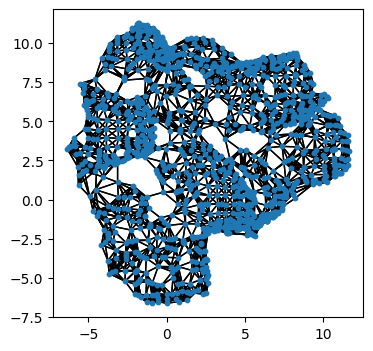

In [23]:
data.edge_index, _ = dense_to_sparse(data.adj)
visualize_points(data.pos, data.edge_index)

In [24]:
batch_size = 5 # cannot change this at the moment

n_train = ceil((4/6) * len(dataset))
n_val = ceil((len(dataset) - n_train)/2)
n_test = len(dataset) - n_train - n_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DenseDataLoader(dataset = train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DenseDataLoader(dataset = val_dataset, batch_size= batch_size, shuffle=True)
test_loader = DenseDataLoader(dataset = test_dataset, batch_size= batch_size, shuffle=True)

Number of training graphs: 1000
Number of validation graphs: 250
Number of test graphs: 250


In [25]:
databatch = next(iter(train_loader))
#databatch.w.dtype
new_adj = databatch.adj * databatch.w
new_adj

tensor([[[0.2596, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.2023, 0.1219,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0996, 0.1654,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1561, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1573, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1394]],

        [[0.2662, 0.1464, 0.0700,  ..., 0.0000, 0.0000, 0.0000],
         [0.1214, 0.2208, 0.1008,  ..., 0.0000, 0.0000, 0.0000],
         [0.0520, 0.0902, 0.1977,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1445, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2023, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1790]],

        [[0.1822, 0.0861, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0829, 0.1756, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3553,  ..., 0.0000, 0.0000, 0.

### Define Network

In [26]:
class GNN(torch.nn.Module):
    def __init__(self, in_nodes, in_channels, hidden_channels, out_channels,
                 normalize=False, lin=True):
        super(GNN, self).__init__()

        # Each instance of this GNN will have 3 convolutional layers and three batch norm layers        
        self.conv1 = GCNConv(in_channels, hidden_channels, normalize)
        self.bns1 = torch.nn.BatchNorm1d(in_nodes)
        
        self.conv2 = GCNConv(hidden_channels, hidden_channels, normalize)
        self.bns2 = torch.nn.BatchNorm1d(in_nodes)
        
        self.conv3 = GCNConv(hidden_channels, out_channels, normalize)
        self.bns3 = torch.nn.BatchNorm1d(in_nodes)


    def forward(self, x, adj, mask=None):
        
        #Step 1
        x = self.conv1(x, adj, mask)
        #print(x.shape)
        x = x = self.bns1(x)
        
        #Step 2
        x = self.conv2(x, adj, mask)
        #print(x.shape)
        x = x = self.bns2(x)

        #Step 3
        x = self.conv3(x, adj, mask)
        #print(x.shape)
        if x.shape[2] != 1: 
            x = x = self.bns3(x)

        return x


class DiffPool(torch.nn.Module):
    def __init__(self, num_nodes):
        super(DiffPool, self).__init__()

        #Hierarchical Step #1
        in_nodes = num_nodes
        out_nodes = 325 # Number of clusters / nodes in the next layer
        self.gnn1_pool = GNN(in_nodes, dataset.num_features, 64, out_nodes, ) # PoolGNN --> Cluster Assignment Matrix to reduce to num_nodes
        self.gnn1_embed = GNN(in_nodes, dataset.num_features, 16, 32) # EmbGNN --> Convolutions to change node feature dim.

        # Hierarchical Step #2
        in_nodes = out_nodes
        out_nodes = 128
        self.gnn2_pool = GNN(in_nodes, 32, 64, out_nodes)
        self.gnn2_embed = GNN(in_nodes, 32, 32, 64, lin=False)

        # Hierarchical Step #3
        in_nodes = out_nodes
        out_nodes = 32
        self.gnn3_pool = GNN(in_nodes, 64, 64, out_nodes)
        self.gnn3_embed = GNN(in_nodes, 64, 64, 128, lin=False)

        # Hierarchical Step #4
        in_nodes = out_nodes
        out_nodes = 16
        self.gnn4_pool = GNN(in_nodes, 128, 64, out_nodes)
        self.gnn4_embed = GNN(in_nodes, 128, 128, 256, lin=False)

        # Hierarchical Step #5
        in_nodes = out_nodes
        out_nodes = 1
        self.gnn5_pool = GNN(in_nodes, 256, 64, out_nodes)
        self.gnn5_embed = GNN(in_nodes, 256, 256, 256, lin=False)

        # Final Classifier
        self.lin1 = torch.nn.Linear(256, 64) 
        self.lin2 = torch.nn.Linear(64, 2)



    def forward(self, x, adj, pos, batch, epoch, mask=None):
        
        #if batch == 0: print('Shape of input data batch:')
        #if batch == 0: print(f'Feature Matrix: {tuple(x.shape)}')
        #if batch == 0: print(f'Adjacency Matrix: {tuple(adj.shape)}')
        #if batch == 0: print(f'Coordinate Matrix: {tuple(pos.shape)}')

        with torch.no_grad():
             if epoch == 10 and batch == 199: torch.save((x.detach(), pos.detach(), adj.detach()), 'img0_data.pt')


        #Hierarchical Step #1
        #if batch == 0: print('Hierarchical Step #1')
        s = self.gnn1_pool(x, adj, mask) # cluster assignment matrix
        x1 = self.gnn1_embed(x, adj, mask) # node feature embedding
        #if batch == 0: print(f'X1 = {tuple(x1.shape)}    S1: {tuple(s.shape)}')

        pos = torch.matmul( torch.softmax( torch.softmax(s, dim=-1).transpose(1, 2), dim=-1), pos)
        x, adj, l1, e1 = dense_diff_pool(x1, adj, s, mask) # does the necessary matrix multiplications
        adj = torch.softmax(adj, dim=-1)

        #if batch == 0: print(f'---matmul---> New feature matrix (softmax(s_0.t()) @ z_0) = {tuple(x.shape)}')
        #if batch == 0: print(f'---matmul---> New adjacency matrix (s_0.t() @ adj_0 @ s_0) = {tuple(adj.shape)}')
        #if batch == 0: print(f'---matmul---> New coordinate matrix ((softmax(s_0.t()) @ pos) = {tuple(pos.shape)}')

        with torch.no_grad():
            if epoch == 10 and batch == 199: torch.save((x1.detach(), x.detach(), pos.detach(), adj.detach(), s.detach()), 'img1_data.pt')


        # Hierarchical Step #2
        #if batch == 0: print('Hierarchical Step #2')
        s = self.gnn2_pool(x, adj)
        x2 = self.gnn2_embed(x, adj)
        #if batch == 0: print(f'X2: {tuple(x2.shape)}    S2: {tuple(s.shape)}')
        
        pos = torch.matmul( torch.softmax( torch.softmax(s, dim=-1).transpose(1, 2), dim=-1), pos)    
        x, adj, l2, e2 = dense_diff_pool(x2, adj, s)
        adj = torch.softmax(adj, dim=-1)

        #if batch == 0: print(f'---matmul---> New feature matrix (softmax(s_0.t()) @ z_0) = {tuple(x.shape)}')
        #if batch == 0: print(f'---matmul---> New adjacency matrix (s_0.t() @ adj_0 @ s_0) = {tuple(adj.shape)}')
        #if batch == 0: print(f'---matmul---> New coordinate matrix ((softmax(s_0.t()) @ pos) = {tuple(pos.shape)}')
        
        with torch.no_grad():
            if epoch == 10 and batch == 199: torch.save((x2.detach(), x.detach(), pos.detach(), adj.detach(), s.detach()), 'img2_data.pt')


        # Hierarchical Step #3
        #if batch == 0: print('Hierarchical Step #3')
        s = self.gnn3_pool(x, adj)
        x3 = self.gnn3_embed(x, adj)
        #if batch == 0: print(f'X3: {tuple(x3.shape)}    S3: {tuple(s.shape)}')

        pos = torch.matmul( torch.softmax( torch.softmax(s, dim=-1).transpose(1, 2), dim=-1), pos)        
        x, adj, l3, e3 = dense_diff_pool(x3, adj, s)
        adj = torch.softmax(adj, dim=-1)

        #if batch == 0: print(f'---matmul---> New feature matrix (softmax(s_0.t()) @ z_0) = {tuple(x.shape)}')
        #if batch == 0: print(f'---matmul---> New adjacency matrix (s_0.t() @ adj_0 @ s_0) = {tuple(adj.shape)}')
        #if batch == 0: print(f'---matmul---> New coordinate matrix ((softmax(s_0.t()) @ pos) = {tuple(pos.shape)}')
        
        with torch.no_grad():
            if epoch == 10 and batch == 199: torch.save((x3.detach(), x.detach(), pos.detach(), adj.detach(), s.detach()), 'img3_data.pt')


        #Hierarchical Step #4
        #if batch == 0: print('Hierarchical Step #1')
        s = self.gnn4_pool(x, adj, mask) # cluster assignment matrix
        x4 = self.gnn4_embed(x, adj, mask) # node feature embedding
        #if batch == 0: print(f'X1 = {tuple(x1.shape)}    S1: {tuple(s.shape)}')

        pos = torch.matmul( torch.softmax( torch.softmax(s, dim=-1).transpose(1, 2), dim=-1), pos)
        x, adj, l1, e1 = dense_diff_pool(x4, adj, s, mask) # does the necessary matrix multiplications
        adj = torch.softmax(adj, dim=-1)

        #if batch == 0: print(f'---matmul---> New feature matrix (softmax(s_0.t()) @ z_0) = {tuple(x.shape)}')
        #if batch == 0: print(f'---matmul---> New adjacency matrix (s_0.t() @ adj_0 @ s_0) = {tuple(adj.shape)}')
        #if batch == 0: print(f'---matmul---> New coordinate matrix ((softmax(s_0.t()) @ pos) = {tuple(pos.shape)}')

        with torch.no_grad():
            if epoch == 10 and batch == 199: torch.save((x4.detach(), x.detach(), pos.detach(), adj.detach(), s.detach()), 'img1_data.pt')


        #Hierarchical Step #5
        #if batch == 0: print('Hierarchical Step #1')
        s = self.gnn5_pool(x, adj, mask) # cluster assignment matrix
        x5 = self.gnn5_embed(x, adj, mask) # node feature embedding
        #if batch == 0: print(f'X1 = {tuple(x1.shape)}    S1: {tuple(s.shape)}')

        pos = torch.matmul( torch.softmax( torch.softmax(s, dim=-1).transpose(1, 2), dim=-1), pos)
        x, adj, l1, e1 = dense_diff_pool(x5, adj, s, mask) # does the necessary matrix multiplications
        adj = torch.softmax(adj, dim=-1)

        #if batch == 0: print(f'---matmul---> New feature matrix (softmax(s_0.t()) @ z_0) = {tuple(x.shape)}')
        #if batch == 0: print(f'---matmul---> New adjacency matrix (s_0.t() @ adj_0 @ s_0) = {tuple(adj.shape)}')
        #if batch == 0: print(f'---matmul---> New coordinate matrix ((softmax(s_0.t()) @ pos) = {tuple(pos.shape)}')

        with torch.no_grad():
            if epoch == 10 and batch == 199: torch.save((x5.detach(), x.detach(), pos.detach(), adj.detach(), s.detach()), 'img1_data.pt')



        # Final Classification
        #if batch == 0: print('Final Classification:')
        x = x.mean(dim=1) # Pool the features of all nodes (global mean pool)  dim = 1 refers to columns
        #if batch == 0: print(f'---X Output 3 after mean= {tuple(x.shape)}')

        x = F.relu(self.lin1(x)) # Fully connected layer + relu
        #if batch == 0: print(f'------ X Output 3 after lin1= {tuple(x.shape)}')

        x = self.lin2(x) # Reduction to num_classes
        #if batch == 0: print(f'--------- X Output 3 after lin2= {tuple(x.shape)}')

        log = F.log_softmax(x, dim=-1)
        #if batch == 0: print(f'------------ LogSoftmax = {log}')
        
        return log, l1 + l2 + l3, e1 + e2 + e3

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPool(num_nodes = 1300).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

node_lengths = []

def train(epoch):
    model.train()
    loss_all = 0

    batch = 0
    for data in train_loader:
        #print(f'BATCH NUMBER {batch}')
        data = data.to(device)
        optimizer.zero_grad()
        data.adj = data.adj * data.w #multiply the adjacency matrix with the weights
        output, _, _ = model(data.x, data.adj, data.pos, batch, epoch) #data.mask
        loss = F.nll_loss(output, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
        batch +=1
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.adj, data.pos, batch = None, epoch = None)[0].max(dim=1)[1] #, data.mask
        correct += pred.eq(data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)


best_val_acc = test_acc = 0
for epoch in range(1, 11):
    train_loss = train(epoch)
    val_acc = test(val_loader)
    if val_acc > best_val_acc:
        test_acc = test(test_loader)
        best_val_acc = val_acc
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Loss: 1.1794, Val Acc: 0.5400, Test Acc: 0.4880
Epoch: 002, Train Loss: 0.7762, Val Acc: 0.4600, Test Acc: 0.4880
Epoch: 003, Train Loss: 0.7409, Val Acc: 0.5400, Test Acc: 0.4880
Epoch: 004, Train Loss: 0.7346, Val Acc: 0.4600, Test Acc: 0.4880
Epoch: 005, Train Loss: 0.7222, Val Acc: 0.4600, Test Acc: 0.4880
Epoch: 006, Train Loss: 0.7022, Val Acc: 0.5400, Test Acc: 0.4880
Epoch: 007, Train Loss: 0.6932, Val Acc: 0.5400, Test Acc: 0.4880
Epoch: 008, Train Loss: 0.6931, Val Acc: 0.5400, Test Acc: 0.4880
Epoch: 009, Train Loss: 0.6932, Val Acc: 0.5400, Test Acc: 0.4880
Epoch: 010, Train Loss: 0.6932, Val Acc: 0.5400, Test Acc: 0.4880
